# More SciPy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fitting

Fitting is used to match a model to experimental data.  E.g. we have N points of $(x_i, y_i)$ with associated errors, $\sigma_i$, and we want to find a simply function that best represents the data.

Usually this means that we will need to define a metric, often called the residual, for how well our function matches the data, and then minimize this residual.  [Least-squares fitting](https://en.wikipedia.org/wiki/Least_squares) is a popular formulation.

We want to fit our data to a function $Y(x, \{a_j\})$, where $a_j$ are model parameters we can adjust.  We want to find the optimal $a_j$ to minimize the distance of $Y$ from our data, *measured parallel to the $y$-axis*:

$$\Delta_i = Y(x_i, \{a_j\}) - y_i$$

[Least-squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) minimizes the distance between the
data points and the model line parallel to the $y$-axis.  We write this as $\chi^2$:

$$\chi^2(\{a_j\}) = \sum_{i=1}^N \left ( \frac{\Delta_i}{\sigma_i} \right )^2$$

In [2]:
from scipy import optimize

### general linear least squares

First we'll make some experimental data (a quadratic with random fashion).  We use the [standard_normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.standard_normal.html) function to provide Gaussian normalized errors.

In [3]:
def y_experiment2(a1, a2, a3, sigma, x):
    """ return the experimental data in a quadratic + random fashion,                              
        with a1, a2, a3 the coefficients of the quadratic and sigma is                             
        the error.  This will be poorly matched to a linear fit for                                
        a3 != 0 """

    N = len(x)

    # standard_normal gives samples from the "standard normal" distribution
    rng = np.random.default_rng()
    r = rng.standard_normal(N)

    y = a1 + a2*x + a3*x*x + sigma*r

    return y

In [4]:
N = 40
sigma = 5.0*np.ones(N)

x = np.linspace(0, 100.0, N)
y = y_experiment2(2.0, 1.50, -0.02, sigma, x)

<ErrorbarContainer object of 3 artists>

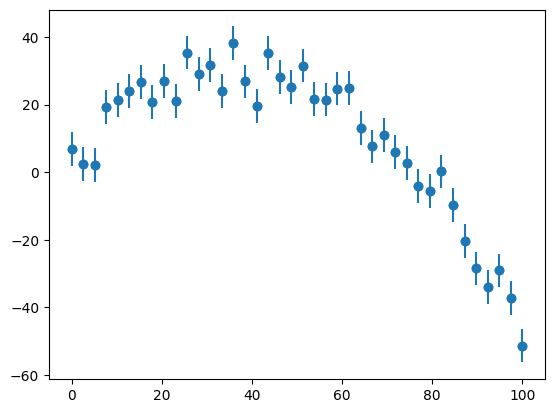

In [5]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.errorbar(x, y, yerr=sigma, fmt="o")

```{note}
"linear" in general linear least squares means that the fit parameters enter into the fitting function linearly,
the function itself can be nonlinear in $x$.
```

We'll use the [leastsq()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html) function to minimize the square of the residual.  

First our function to compute the residual.

In [6]:
def resid(avec, x, y, sigma):
    """ the residual function -- this is what will be minimized by the
        scipy.optimize.leastsq() routine.  avec is the parameters we
        are optimizing -- they are packed in here, so we unpack to
        begin.  (x, y) are the data points 

        scipy.optimize.leastsq() minimizes:

           x = arg min(sum(func(y)**2,axis=0))
                    y

        so this should just be the distance from a point to the curve,
        and it will square it and sum over the points
        """

    a0, a1, a2 = avec
    
    return (y - (a0 + a1*x + a2*x**2))/sigma

In [7]:
# initial guesses
a0, a1, a2 = 1, 1, 1

afit, flag = optimize.leastsq(resid, [a0, a1, a2], args=(x, y, sigma))

print(afit)

[ 4.52310639  1.4221583  -0.01936907]


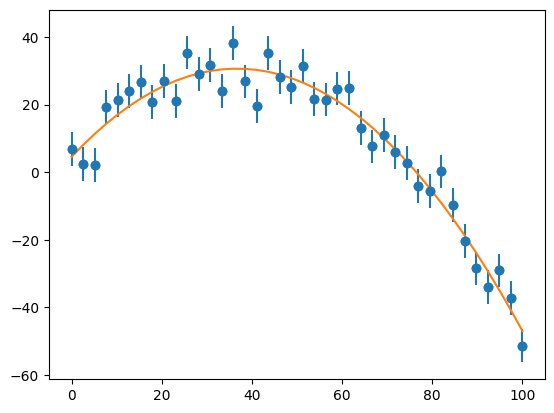

In [8]:
ax.plot(x, afit[0] + afit[1]*x + afit[2]*x*x )
fig

We see that we represent the data quite well.

We can compute the [reduced $\chi^2$](https://en.wikipedia.org/wiki/Ordinary_least_squares#Reduced_chi-squared)

In [9]:
chisq = sum(np.power(resid(afit, x, y, sigma),2))
normalization = len(x)-len(afit)
print(chisq/normalization)

1.0074985735289523


In general a (reduced) $\chi^2 < 1$ indicates a good fit.

### a nonlinear example

The same interface works with nonlinear data.

We'll create a new set of experimental data---an exponential

In [10]:
a0 = 2.5
a1 = 2./3.
sigma = 5.0

a0_orig, a1_orig = a0, a1

rng = np.random.default_rng()

x = np.linspace(0.0, 4.0, 25)
y = a0*np.exp(a1*x) + sigma * rng.standard_normal(len(x))

<ErrorbarContainer object of 3 artists>

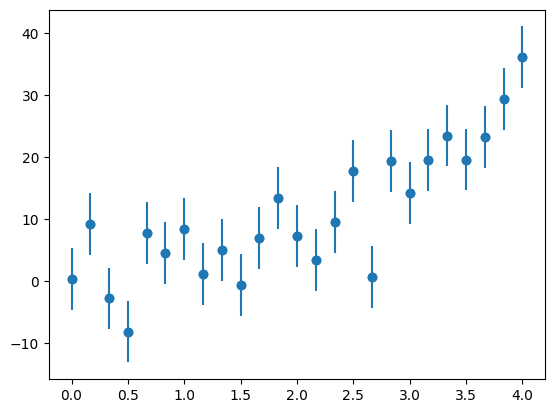

In [11]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.errorbar(x, y, yerr=sigma, fmt="o", label="_nolegend_")

our function to minimize

In [12]:
def resid(avec, x, y):
    """ the residual function -- this is what will be minimized by the                             
        scipy.optimize.leastsq() routine.  avec is the parameters we                               
        are optimizing -- they are packed in here, so we unpack to                                 
        begin.  (x, y) are the data points                                                         
                                                                                                   
        scipy.optimize.leastsq() minimizes:                                                        
                                                                                                   
           x = arg min(sum(func(y)**2,axis=0))                                                     
                    y                                                                              
                                                                                                   
        so this should just be the distance from a point to the curve,                             
        and it will square it and sum over the points                                              
        """

    a0, a1 = avec

    # note: if we wanted to deal with error bars, we would weight each                             
    # residual accordingly                                                                         
    return y - a0*np.exp(a1*x)

In [13]:
a0, a1 = 1, 1
afit, flag = optimize.leastsq(resid, [a0, a1], args=(x, y))

print(flag)
print(afit)

1
[1.51837198 0.77613648]


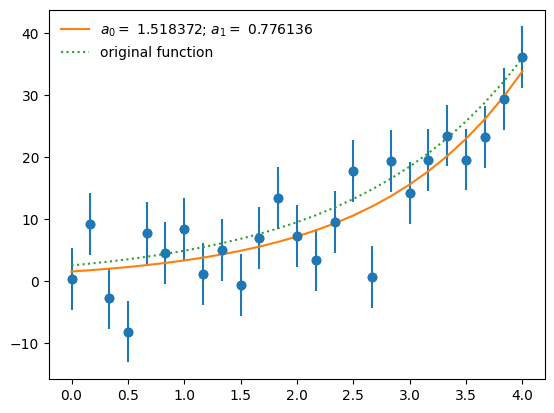

In [14]:
ax.plot(x, afit[0]*np.exp(afit[1]*x),
           label=r"$a_0 = $ %f; $a_1 = $ %f" % (afit[0], afit[1]))
ax.plot(x, a0_orig*np.exp(a1_orig*x), ":", label="original function")
ax.legend(numpoints=1, frameon=False)
fig

```{note}
What about uncertainties in both $x$ and $y$?  SciPy has an
[orthogonal distance regression](https://docs.scipy.org/doc/scipy/reference/odr.html) implementation based on ODRPACK for this.
```

## FFTs

[Fourier transforms](https://en.wikipedia.org/wiki/Fourier_transform) convert a physical-space (or time series) representation of a function into frequency space.  This provides an equivalent representation of the data with a new view.

The FFT and its inverse in NumPy use:

$$F_k = \sum_{n=0}^{N-1} f_n e^{-2\pi i nk/N}$$

$$f_n = \frac{1}{N} \sum_{k=0}^{N-1} F_k 
   e^{2\pi i n k/N}$$
   

Both NumPy and SciPy have FFT routines that are similar.  However, the NumPy version returns the data in a more convenient form.

```{tip}
It's always best to start with something you understand---let's do a simple sine wave.  Since our function is real, we can use the rfft routines in NumPy---the understand that we are working with real data and they don't return the negative frequency components.
```

```{important}
FFTs assume that you are periodic.  If you include both endpoints of the domain in the points that comprise your sample then you will not match this assumption.  Here we use `endpoint=False` with `linspace()`
```

```{note}
For real-valued data, we'll use `np.fft.rfft()`, which will return N/2 complex values given N real samples.

To get the frequencies, we can use `np.fft.rfftfreq()`, which will return dimensionless frequencies of the form
$0, 1/N, 2/N, 3/N, ...$.  We know that the shortest lowest frequency corresponds to a single wavelength in the domain, so physically, $1/N$ corresponds to a frequency $1/L$, where $L$ is the domain size.  This means that
we can convert the frequencies by dividing by $\Delta x =  L/N$.
```

To make our life easier, we'll define a function that plots all the stages of the FFT process

In [15]:
def plot_FFT(xx, f):

    npts = len(xx)
    dx = xx[1] - xx[0]

    # Forward transform: f(x) -> F(k)
    fk = np.fft.rfft(f)

    # Normalization -- the '2' here comes from the fact that we are
    # neglecting the negative portion of the frequency space, since
    # the FFT of a real function contains redundant information, so
    # we are only dealing with 1/2 of the frequency space.
    #
    # technically, we should only scale the 0 bin by N, since k=0 is
    # not duplicated -- we won't worry about that for these plots
    norm = 2.0 / npts

    fk = fk * norm

    fk_r = fk.real
    fk_i = fk.imag

    # rfftfreq returns the frequencies as 0, 1/N, 2/N, 3/N, ...
    k = np.fft.rfftfreq(npts)

    # to make these dimensional, we need to divide by dx.
    kfreq = k / dx

    # Inverse transform: F(k) -> f(x) -- without the normalization
    fkinv = np.fft.irfft(fk/norm)

    # plots
    fig, ax = plt.subplots(nrows=4, ncols=1)
    
    ax[0].plot(xx, f)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("f(x)")

    ax[1].plot(kfreq, fk_r, label=r"Re($\mathcal{F}$)")
    ax[1].plot(kfreq, fk_i, ls=":", label=r"Im($\mathcal{F}$)")
    ax[1].set_xlabel(r"$\nu_k$")
    ax[1].set_ylabel("F(k)")

    ax[1].legend(fontsize="small", frameon=False)

    ax[2].plot(kfreq, np.abs(fk))
    ax[2].set_xlabel(r"$\nu_k$")
    ax[2].set_ylabel(r"|F(k)|")

    ax[3].plot(xx, fkinv.real)
    ax[3].set_xlabel(r"$\nu_k$")
    ax[3].set_ylabel(r"inverse F(k)")

    f = plt.gcf()
    
    f.set_size_inches(10,8)
    plt.tight_layout()


Now we'll test it on $f(x) = \sin(2\pi \nu_0 x)$, where $\nu_0$ is a frequency we set.

In [16]:
def single_freq_sine(npts):

    # a pure sine with no phase shift will result in pure imaginary
    # signal
    f_0 = 0.2

    xmax = 10.0/f_0
    
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.sin(2.0*np.pi*f_0*xx)

    return xx, f

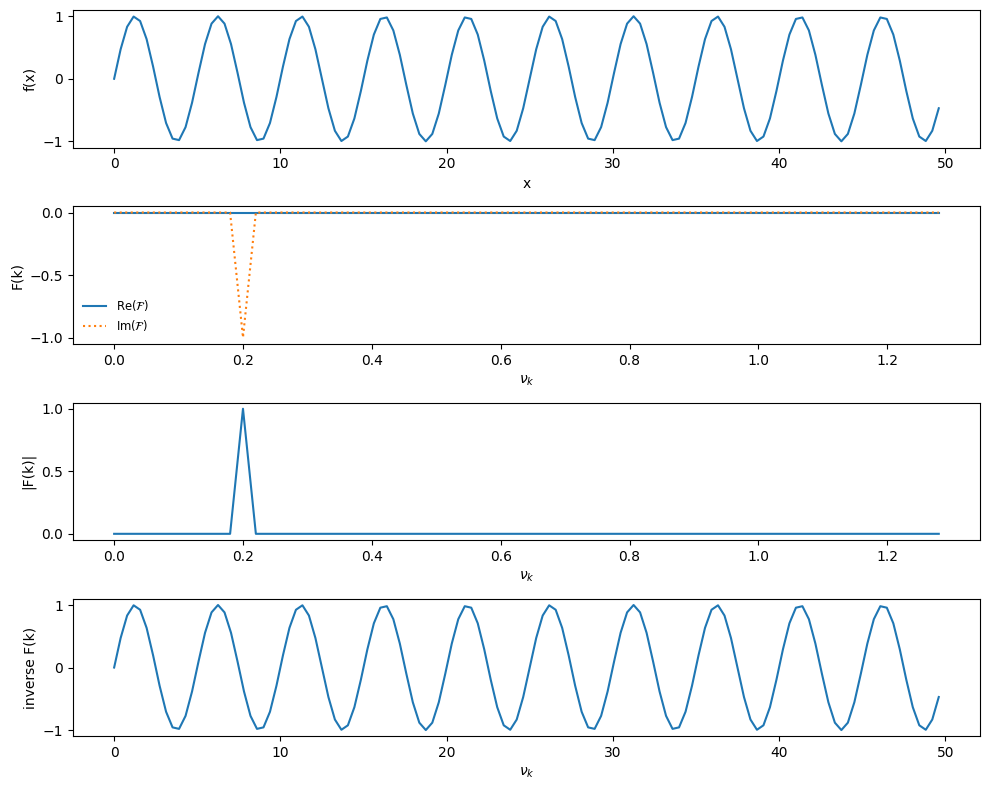

In [17]:
npts = 128
xx, f = single_freq_sine(npts)
plot_FFT(xx, f)

Notice that all of the power is at our single frequency, *and* it is all in the imaginary components, which is expected since $e^{ix} = \cos(x) + i\sin(x)$

Next, we can try $f(x) = \cos(2\pi\nu_0 x)$, and we know that a cosine is just a sine shifted in phase by $\pi/2$.

In [18]:
def single_freq_cosine(npts):

    # a pure cosine with no phase shift will result in pure real
    # signal
    f_0 = 0.2

    xmax = 10.0/f_0

    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.cos(2.0*np.pi*f_0*xx)

    return xx, f

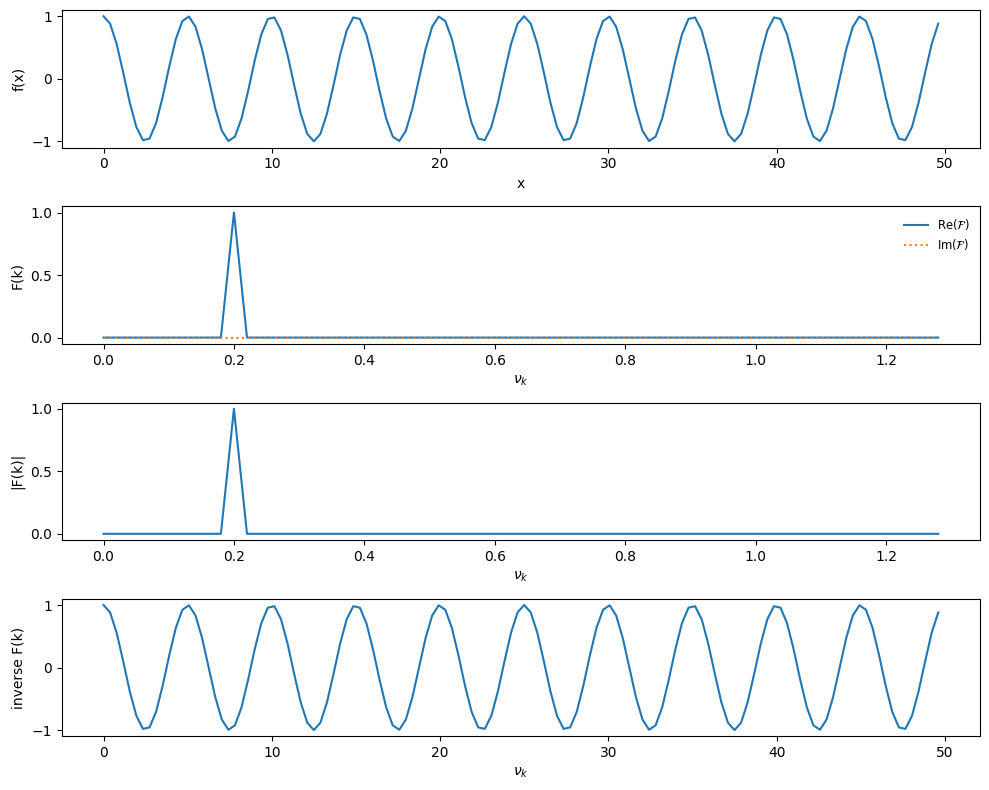

In [19]:
xx, f = single_freq_cosine(npts)
plot_FFT(xx, f)

Now, as expected, all of the power is in the real component.

Now let's look at a sine with a $\pi/4$ phase shift

In [20]:
def single_freq_sine_plus_shift(npts):

    # a pure sine with no phase shift will result in pure imaginary
    # signal
    f_0 = 0.2

    xmax = 10.0/f_0

    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.sin(2.0*np.pi*f_0*xx + np.pi/4)

    return xx, f

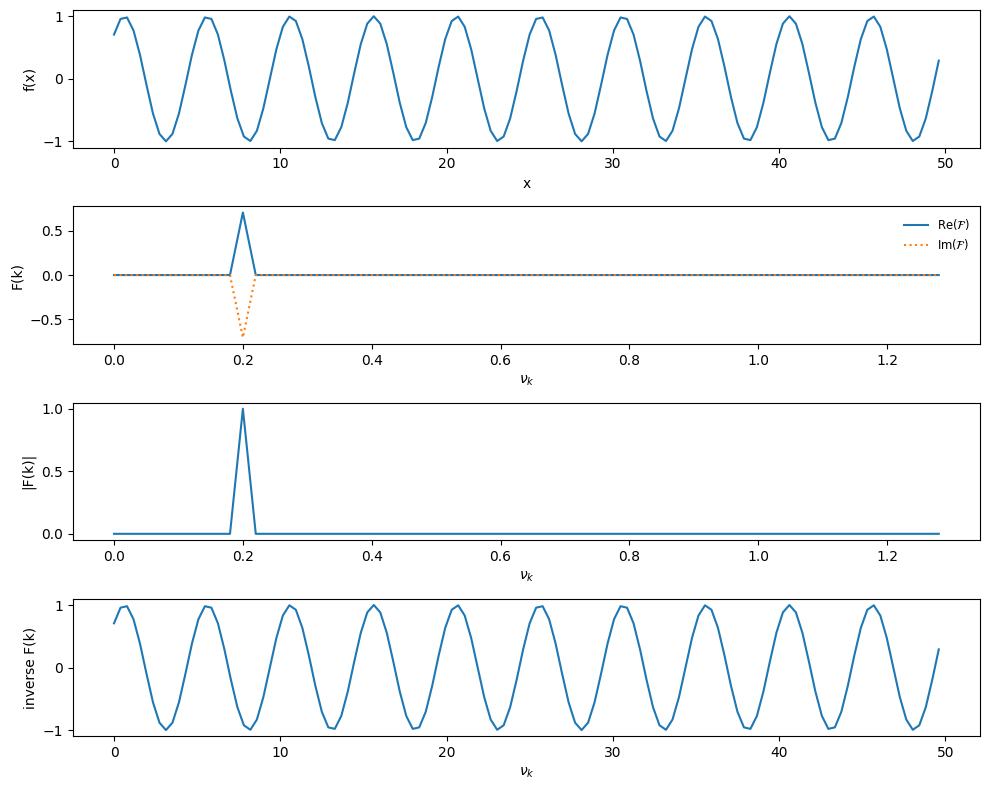

In [21]:
xx, f = single_freq_sine_plus_shift(npts)
plot_FFT(xx, f)

No surprise---the power is now equally in the real and imaginary parts.

### A frequency filter

we'll setup a simple two-frequency sine wave and filter a component

In [22]:
def two_freq_sine(npts):

    # a pure sine with no phase shift will result in pure imaginary             
    # signal                                                                    
    f_0 = 0.2
    f_1 = 0.5

    xmax = 10.0/f_0

    # we call with endpoint=False -- if we include the endpoint, then for       
    # a periodic function, the first and last point are identical -- this       
    # shows up as a signal in the FFT.                                          
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = 0.5*(np.sin(2.0*np.pi*f_0*xx) + np.sin(2.0*np.pi*f_1*xx))

    return xx, f

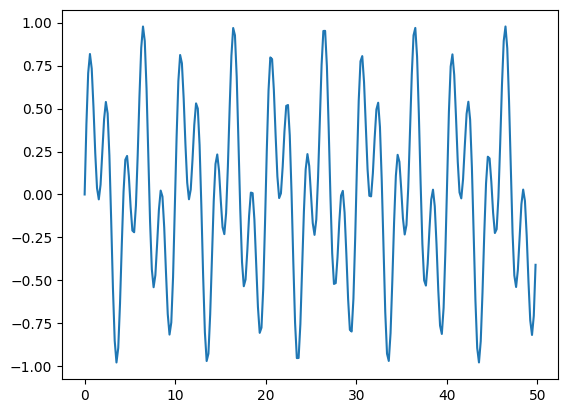

In [23]:
npts = 256

xx, f = two_freq_sine(npts)

fig, ax = plt.subplots()
ax.plot(xx, f)

we'll take the transform: $f(x) \rightarrow F(k)$

In [24]:
# normalization factor: the 2 here comes from the fact that we neglect          
# the negative portion of frequency space because our input function            
# is real                                                                       
norm = 2.0/npts
fk = norm*np.fft.rfft(f)

ofk_r = fk.real.copy()
ofk_i = fk.imag.copy()

# get the frequencies
k = np.fft.rfftfreq(len(xx))

# since we don't include the endpoint in xx, to normalize things, we need       
# max(xx) + dx to get the true length of the domain
#
# This makes the frequencies essentially multiples of 1/dx
kfreq = k*npts/(max(xx) + xx[1])

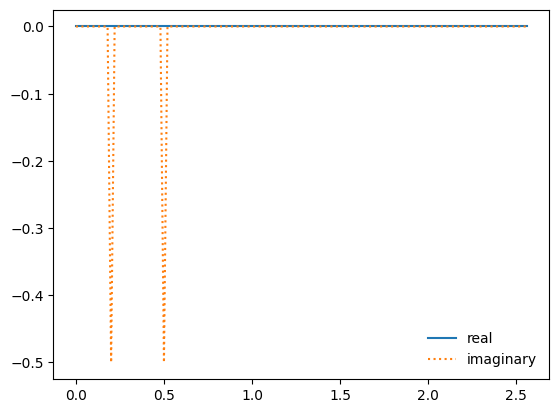

In [25]:
fig, ax = plt.subplots()
ax.plot(kfreq, fk.real, label="real")
ax.plot(kfreq, fk.imag, ":", label="imaginary")
ax.legend(frameon=False)

Now we can filter out the higher frequencies---this is done in Fourier space.

In [26]:
fk[kfreq > 0.4] = 0.0

# element 0 of fk is the DC component                                           
fk_r = fk.real
fk_i = fk.imag

Finally, transform back.

In [27]:
# Inverse transform: F(k) -> f(x)                                               
fkinv = np.fft.irfft(fk/norm)

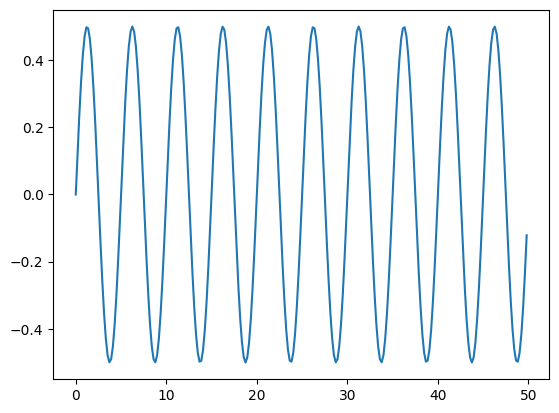

In [28]:
fig, ax = plt.subplots()
ax.plot(xx, fkinv.real)

## Linear Algebra

### general manipulations of matrices

You can use regular NumPy arrays or you can use a special matrix class that offers some short cuts.

```{tip}
Since the introduction of the matrix multiplication operator, `@`, using the numpy matrix class is no longer recommended.
```

Let's create a simply 2x2 matrix, ${\bf A}$

In [29]:
a = np.array([[1.0, 2.0],
              [3.0, 4.0]])

In [30]:
print(a)
print(a.transpose())
print(a.T)

[[1. 2.]
 [3. 4.]]
[[1. 3.]
 [2. 4.]]
[[1. 3.]
 [2. 4.]]


We can solve for the inverse

In [31]:
ainv = np.linalg.inv(a)
print(ainv)

[[-2.   1. ]
 [ 1.5 -0.5]]


And multiply ${\bf A}$ by its inverse, ${\bf A}^{-1}$

In [32]:
a @ ainv

array([[1.0000000e+00, 0.0000000e+00],
       [8.8817842e-16, 1.0000000e+00]])

the eye() function will generate an identity matrix (as will the identity())

In [33]:
print(np.eye(2))
print(np.identity(2))

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]


### Linear systems
we can solve ${\bf A}{\bf x} = {\bf b}$ easily.

```{note}
Linear system solvers don't usually compute the inverse first and then multiply
by it.  It is much cheaper to solve the system directly (e.g., via Gaussian elimination)
than to first compute the inverse.
```

In [34]:
b = np.array([5, 7])
x = np.linalg.solve(a, b)
print(x)

[-3.  4.]


### tridiagonal matrix solve

Here we'll solve the Poisson problem:

$$f^{\prime\prime} = g(x)$$

with $g(x) = \sin(x)$, and the domain $x \in [0, 2\pi]$, with boundary conditions $f(0) = f(2\pi) = 0$.

The solution is simply $f(x) = -\sin(x)$.

We'll use a grid of $N$ points with $x_0$ on the left boundary and $x_{N-1}$ on the right boundary.

We difference our equation as:

$$f_{i+1} - 2 f_i + f_{i-1} = \Delta x^2 g_i$$

We keep the boundary points fixed, so we only need to solve for the $N-2$ interior points.  Near the boundaries, our difference is:

$$f_2 - 2 f_1 = \Delta x^2 g_1$$

and

$$-2f_{N-1} + f_{N-2} = \Delta x^2 g_{N-1}$$

We can write the system of equations for solving for the $N-2$ interior points as:

$${\bf A} = \left (
\begin{array}{ccccccc}
-2 &  1 &    &        &         &           &          \newline
1  & -2 &  1 &        &         &           &          \newline
   &  1 & -2 & 1      &         &           &          \newline
   &         & \ddots & \ddots & \ddots  &           &          \newline
   &         &        & \ddots & \ddots  & \ddots  &          \newline
   &         &        &        & 1       & -2 & 1  \newline
   &         &        &        &         & 1  & -2 \newline
\end{array}
\right )
$$

$$
{\bf x} = \left (
\begin{array}{c}
f_\mathrm{1} \\\
f_\mathrm{2} \\\
f_\mathrm{3} \\\
\vdots \\\
\vdots \\\
f_\mathrm{N-2} \\\
f_\mathrm{N-1} \\\
\end{array}
\right )
$$

$$
{\bf b} = \Delta x^2 \left (
\begin{array}{c}
g_\mathrm{1} \\\
g_\mathrm{2} \\\
g_\mathrm{3} \\\
\vdots \\\
\vdots \\\
g_\mathrm{N-2} \\\
g_\mathrm{N-1}\\\
\end{array}
\right )
$$

Then we just solve ${\bf A}{\bf x} = {\bf b}$

```{note}
SciPy has banded solvers that work with banded matrices like we have above.  They
will be much more efficient than using a solver based on a dense matrix
```

In [35]:
import scipy.linalg as linalg

# our grid -- including endpoints
N = 100
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
dx = x[1] - x[0]

# our source
g = np.sin(x)

# our matrix will be tridiagonal, with [1, -2, 1] on the diagonals
# we only solve for the N-2 interior points

# diagonal
d = -2 * np.ones(N-2)

# upper -- note that the upper diagonal has 1 less element than the
# main diagonal.  The SciPy banded solver wants the matrix in the 
# form:
#
# *    a01  a12  a23  a34  a45    <- upper diagonal
# a00  a11  a22  a33  a44  a55    <- diagonal
# a10  a21  a32  a43  a54   *     <- lower diagonal
#

u = np.ones(N-2)
u[0] = 0.0

# lower
l = np.ones(N-2)
l[N-3] = 0.0

# put the upper, diagonal, and lower parts together as a banded matrix
A = np.matrix([u, d, l])

# solve A sol = dx**2 g for the inner N-2 points
sol = linalg.solve_banded((1,1), A, dx**2*g[1:N-1])

Let's plot the solution

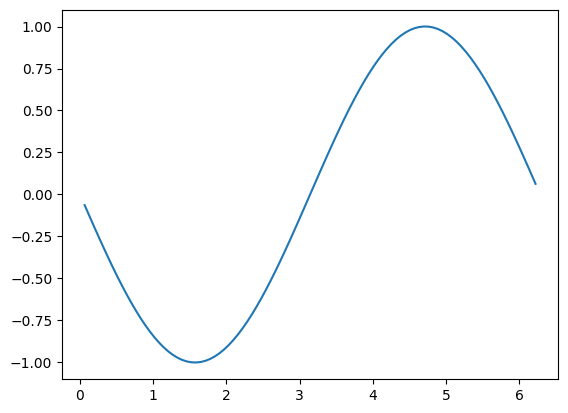

In [36]:
fig, ax = plt.subplots()
ax.plot(x[1:N-1], sol)

This looks like $-\sin(x)$, as expected.